# <center> 🏙️ O L I M P O 🏙️ </center>

### <center> Análise Exploratória </center>
 

## 0. Configurações

### 0.1 Importações

In [2]:
import pandas as pd
import seaborn as sns
import re
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import os
import graphviz

### 0.2 Classificadores e Pré-Processadores

In [3]:
classificador_tree = tree.DecisionTreeClassifier()
classificador_gauss = GaussianNB()
classificador_knn = KNeighborsClassifier()

# Resposta
encoder = LabelEncoder()

# Atributos
preprocessador = ColumnTransformer(
    transformers=[
        ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object'])),
    ],
    remainder='passthrough', 
    verbose_feature_names_out = False   
)

## 1. Pré-Processamento dos Dados 

A base tem 20 colunas, sendo dessas:
- 12 pertencem a X (outras)
- 1 pertence a Y (implementa_app)
- 6 não possuem relevânca para X ('ID', 'Hora de início', 'Hora de conclusão', 'Email', 'Nome', 'Termo de Anonimato', 'Nivel de Satisfação com a Plataforma Utilizada')

Além disso, a Y está desbalanceada, composta por:
- 75 <= SIM (classe majoritária)
- 18 >= NÃO (classe minoritária)

In [4]:
df_olimpo = pd.read_excel("Olimpo.xlsx")

In [5]:
df_olimpo['Você implementaria nosso aplicativo em sua rotina?'].value_counts()

Você implementaria nosso aplicativo em sua rotina?
Sim    75
Não    18
Name: count, dtype: int64

### 1.1 Tratamento

#### 1.1.1 Renomear colunas

In [6]:
df_olimpo = df_olimpo.rename(columns={
    'ID': 'id',
    'Hora de início': 'inicio',
    'Hora de conclusão': 'conclusao',
    'Termo de Anonimato\xa0': 'anonimato',
    'Em que cidade você vive atualmente?': 'cidade',
    'Qual é seu tipo da sua moradia?': 'tipo_moradia',
    'Com quantas pessoas você divide sua casa/apartamento?': 'pessoas_casa',
    'Qual é o seu nível de satisfação com a comunicação dentro da comunidade em que você vive?\nEssa comunidade pode ser seu condomínio, bairro ou a\xa0vizinhança em geral.\n': 'satisfacao_comunicacao_comunidade',
    'Com que frequência você entra em contato com as pessoas que vivem próximas a você?\n\n': 'frequencia_contato',
    'Você acredita que a comunicação entre a comunidade seja importante?': 'comunicacao_importante',
    'Você utiliza alguma plataforma direcionada a gestão e comunicação do bairro ou condomínio/prédio em que vive?': 'usa_plataforma',
    'Qual é o seu nível de satisfação com essa plataforma?': 'satisfacao_plataforma',
    'Em qual faixa etária em que você se encontra atualmente?': 'faixa_etaria',
    'Qual dessas opções representa mais a sua qualidade de vida atual?': 'qualidade_vida',
    'Qual é a sua situação no mercado de trabalho?': 'situacao_trabalho',
    'Em qual renda familiar mensal você se encontra?\xa0\nAs faixas representam:\nClasse A - superior a R$ 28,2 mil\nClasse B -\xa0entre R$ 14,1 mil e R$ 28,2 mil\nClasse C -\xa0entre R$ 5,6 mil e R$ 14,1 mil\nClass...': 'renda_familiar',
    'Você possui animais de estimação?': 'tem_animais',
    'Você implementaria nosso aplicativo em sua rotina?': 'implementa_app'
})

#### 1.1.2 Extrair cidades da coluna cidade

In [7]:
siglas_estados = [
    'AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 
    'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO'
]

nomes_estados = [
    'Acre', 'Alagoas', 'Amapá', 'Amazonas', 'Bahia', 'Ceará', 'Distrito Federal', 'Espírito Santo', 
    'Goiás', 'Maranhão', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Pará', 'Paraíba', 
    'Paraná', 'Pernambuco', 'Piauí', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 
    'Rondônia', 'Roraima', 'Santa Catarina', 'São Paulo', 'Sergipe', 'Tocantins'
]

def extrair_cidade(valor):
    valor = valor.strip()
    for sigla in siglas_estados:
        if re.search(fr'[\s,.-]+{sigla}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{sigla}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    for nome in nomes_estados:
        if re.search(fr'[\s,.-]+{nome}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{nome}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    valor = re.sub(r'[\s,.-]+capital\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    return valor.title()

df_olimpo['cidade'] = df_olimpo['cidade'].apply(extrair_cidade)

#### 1.1.3 Extração das opções

In [8]:
df_olimpo['frequencia_contato'] = df_olimpo['frequencia_contato'].str.replace(r'\s*\(.*\)', '', regex=True)

### 1.2 Limpeza

#### 1.2.1 Remover colunas indesejadas

In [9]:
df_olimpo = df_olimpo.drop(columns=['inicio', 'conclusao', 'Email', 'Nome', 'anonimato', 'satisfacao_plataforma'], axis=1)

In [10]:
df_olimpo.to_excel('Olimpo_cleaned.xlsx', index=False)

## 2. Divisão do DataFrame

### 2.1 Processando as colunas

In [11]:
label = LabelEncoder()

df_olimpo_processado = df_olimpo

for i in df_olimpo_processado.columns:
    if str(df_olimpo_processado[i].dtype) == 'object':
        df_olimpo_processado[i] = label.fit_transform(df_olimpo_processado[i])

### 2.2 Atributos(X) e Resposta(Y)

In [12]:
atributos = df_olimpo_processado.drop('implementa_app', axis=1)
resposta = df_olimpo_processado['implementa_app']

## 3. Classificador

Nesse passo, iremos decidir com o Grid qual é o classificador com a melhor classificação de acordo com o GridCv

## 5. Cross Validation

Como podemos observar na célula abaixo, o Fold escolhido foi o 4, com melhor desempenho em todas as métricas:

In [34]:
metricas = ["accuracy", "precision", "recall", "f1"]

cv = KFold(n_splits=4, shuffle=True, random_state=0)

classificador = GaussianNB()

for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(classificador, atributos.values, resposta.values, cv=cv, scoring=i)
    print(score, score.mean())

print(max(score))

Métrica - accuracy
[0.75       0.69565217 0.7826087  0.86956522] 0.7744565217391304
Métrica - precision
[0.76190476 0.8        0.85       0.9047619 ] 0.8291666666666666
Métrica - recall
[0.94117647 0.84210526 0.89473684 0.95      ] 0.9070046439628483
Métrica - f1
[0.84210526 0.82051282 0.87179487 0.92682927] 0.8653105559395675
0.926829268292683


In [14]:
(train_index, test_index) = tuple(cv.split(df_olimpo_processado))[3]

# Treino e Teste

In [15]:
atributos_treino, resposta_treino = df_olimpo_processado.iloc[train_index,:-1], df_olimpo_processado.iloc[train_index,-1].to_frame()
atributos_teste, resposta_teste = df_olimpo_processado.iloc[test_index,:-1], df_olimpo_processado.iloc[test_index,-1].to_frame()

# Predição

In [16]:
classificador.fit(atributos_treino, resposta_treino)

C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

In [17]:
classificacao = classificador.predict(atributos_teste)

# Avaliação

Ao avaliar o modelo, temos que:

##### -------> Accuracy (geral)
- 93 registros
- A média de acertos em relação a ambas as classes é de 75%

##### -------> Classe Não (0)
- 7 registros
- precision: 67%, acerto da classe 0 sobre oque o modelo disse ser 0
- recall:    29%, acerto da classe 0 sobre oque realmente era 0
- f1-score:  40%, a média harmônica de ambas métricas

##### -------> Classe Sim (1)
- 17 registros
- precision: 76%, acerto da classe 1 sobre oque o modelo disse ser 1
- recall:    94%, acerto da classe 1 sobre oque realmente era 1
- f1-score:  84%, a média harmônica de ambas métricas

##### -------> Conclusão

Com isso, vimos que o modelo não performou bem em relação a classe 0, diferentemente da classe 1, devido ao desbalanceamento das classes.

In [18]:
print(f"Accuracy: {accuracy_score(resposta_teste, classificacao) :.2f}")
print(f"Precision: {precision_score(resposta_teste, classificacao)}")
print(f"Recall: {recall_score(resposta_teste, classificacao)}")
print(f"F1-Score: {f1_score(resposta_teste, classificacao)}")

matrix = confusion_matrix(resposta_teste, classificacao)
print("Confusion Matrix \n", matrix)

Accuracy: 0.87
Precision: 0.9047619047619048
Recall: 0.95
F1-Score: 0.926829268292683
Confusion Matrix 
 [[ 1  2]
 [ 1 19]]


In [19]:
relatorio = classification_report(resposta_teste, classificacao)
print("Relatório de Métricas")
print(relatorio)

Relatório de Métricas
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.90      0.95      0.93        20

    accuracy                           0.87        23
   macro avg       0.70      0.64      0.66        23
weighted avg       0.85      0.87      0.86        23



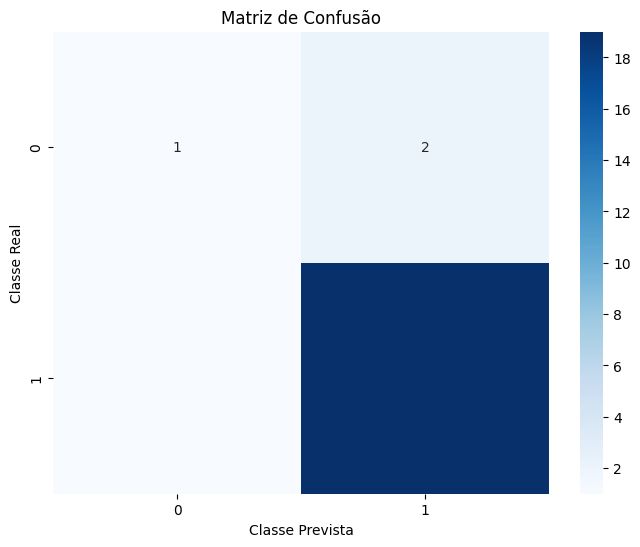

In [20]:
classes = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Duplicando os dados

Para tentar melhorar o desempenho, temos duas opções:

- Diminuir registros da classe 1, cortando dados existentes fora
- Aumentar registros da classe 0, criando dados sintéticos

Como a classe 0 representa apenas 24% de todos os dados, aumentaremos a classe 0, balanceando tudo. 

## Manualmente apenas na base de treino

Relatório de Métricas
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.88      0.75      0.81        20

    accuracy                           0.70        23
   macro avg       0.52      0.54      0.52        23
weighted avg       0.79      0.70      0.73        23



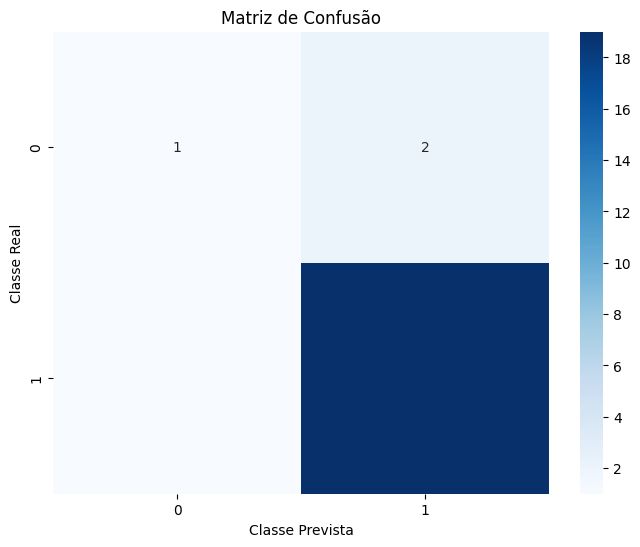

In [21]:
df_treino = pd.concat([atributos_treino, resposta_treino], axis=1)

df_treino_menor50 = df_treino[df_treino["implementa_app"]==0]

df_treino_sint = pd.concat([df_treino, df_treino_menor50.sample(frac=1).reset_index(drop=True), df_treino_menor50.sample(frac=1).reset_index(drop=True)], axis=0)

classificador.fit(df_treino_sint.drop("implementa_app",axis=1), df_treino_sint["implementa_app"])
classificacao = classificador.predict(atributos_teste)

relatorio = classification_report(resposta_teste, classificacao)
print("Relatório de Métricas")
print(relatorio)

classes = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

## SMOTE apenas na Base de treino

- O processo de SMOTE cria dados a partir dos registros do dataset igualmente. Ao por k_neigbors=5, ele se baseiará nos 5 pontos mais próximos para criar um novo dado

- Não houve praticamente perca de desempenho, mas sim melhoria em relação a classe 0. Assim, podemos dizer que houve impacto positivo

Relatório de Métricas
              precision    recall  f1-score   support

           0       0.17      0.33      0.22         3
           1       0.88      0.75      0.81        20

    accuracy                           0.70        23
   macro avg       0.52      0.54      0.52        23
weighted avg       0.79      0.70      0.73        23



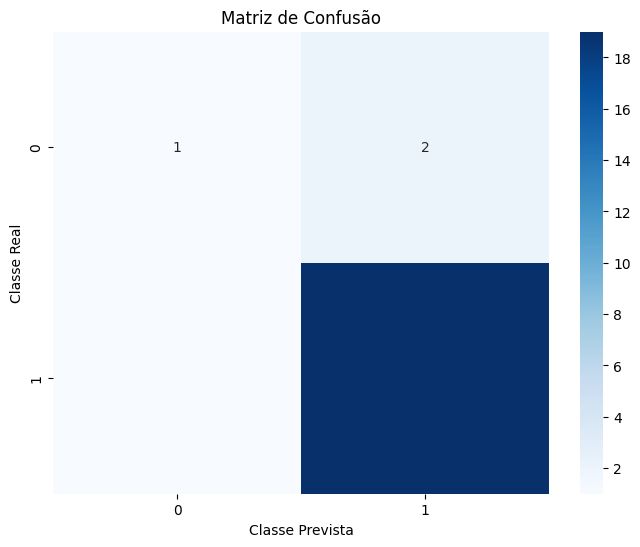

In [22]:
smote = SMOTE(k_neighbors = 5, random_state = 0) 
atributos_treino_smote, resposta_treino_smote = smote.fit_resample(atributos, resposta)

classificador.fit(atributos_treino_smote, resposta_treino_smote)
classificacao = classificador.predict(atributos_teste)

relatorio = classification_report(resposta_teste, classificacao)
print("Relatório de Métricas")
print(relatorio)

classes = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

## RandomOverSampling apenas na Base de Treino

- Diferente do SMOTE, o RandomOverSample cria pontos no dataset aleatóriamente, não havendo um espalhamento igual. Apesar disso, não deixou de ter impacto positivo

- Apesar da pouca diferença, o SMOTE ainda se saiu superior

C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Relatório de Métricas
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.89      0.85      0.87        20

    accuracy                           0.78        23
   macro avg       0.57      0.59      0.58        23
weighted avg       0.81      0.78      0.80        23



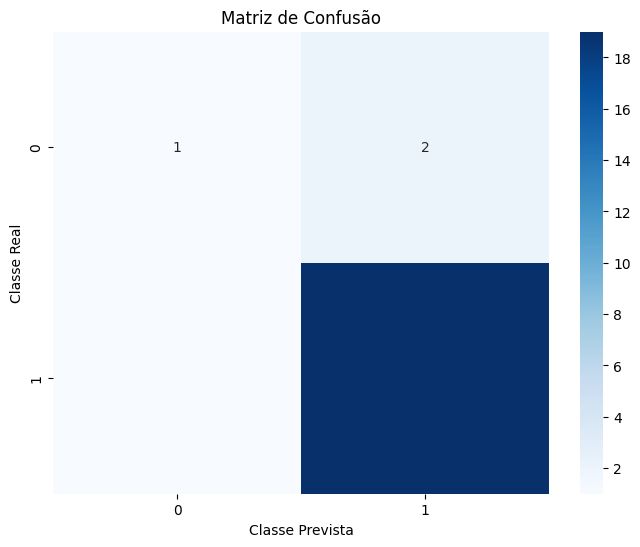

In [23]:
random_Oversample = RandomOverSampler(random_state=0)
atributos_treino_ros, resposta_treino_ros = random_Oversample.fit_resample(atributos_treino, resposta_treino)


classificador.fit(atributos_treino_ros, resposta_treino_ros)
classificacao = classificador.predict(atributos_teste)

relatorio = classification_report(resposta_teste, classificacao)
print("Relatório de Métricas")
print(relatorio)

classes = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

## Base toda - Oversampling

- Outra opção seria aplicar o SMOTE na base toda. Porém eu acredito que isso não seja bom, pois além de criar dados de treino, você está indo além e criando dados de testes falsos.

- Ele teve o segundo pior desempenho, atrás apenas da fase de duplicar dados, assim, temos um veredito que é o SMOTE apenas na base de treino

In [24]:
atributos_smote, resposta_smote = smote.fit_resample(atributos, resposta)

metricas = ["accuracy", "precision", "recall", "f1"]

for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(classificador, atributos_smote.values, resposta_smote.values,cv=cv, scoring=i)
    print(score,score.mean())
    
df_olimpo_smote = pd.concat([atributos_smote, resposta_smote],axis=1)

Métrica - accuracy
[0.68421053 0.65789474 0.64864865 0.67567568] 0.6666073968705548
Métrica - precision
[0.8        0.61111111 0.61538462 0.66666667] 0.6732905982905982
Métrica - recall
[0.66666667 0.64705882 0.5        0.66666667] 0.6200980392156863
Métrica - f1
[0.72727273 0.62857143 0.55172414 0.66666667] 0.6435587401104642


In [25]:
(train_index_smote, test_index_smote) = tuple(cv.split(df_olimpo_smote))[0]
atributos_treino_smote_all, resposta_treino_smote_all = df_olimpo_smote.iloc[train_index_smote,:-1], df_olimpo_smote.iloc[train_index_smote,-1].to_frame()
atributos_teste_smote_all, resposta_teste_smote_all = df_olimpo_smote.iloc[test_index_smote,:-1], df_olimpo_smote.iloc[test_index_smote,-1].to_frame()

C:\Users\sofiadomingues-ieg\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Relatório de Métricas
              precision    recall  f1-score   support

           0       0.56      0.71      0.62        14
           1       0.80      0.67      0.73        24

    accuracy                           0.68        38
   macro avg       0.68      0.69      0.68        38
weighted avg       0.71      0.68      0.69        38



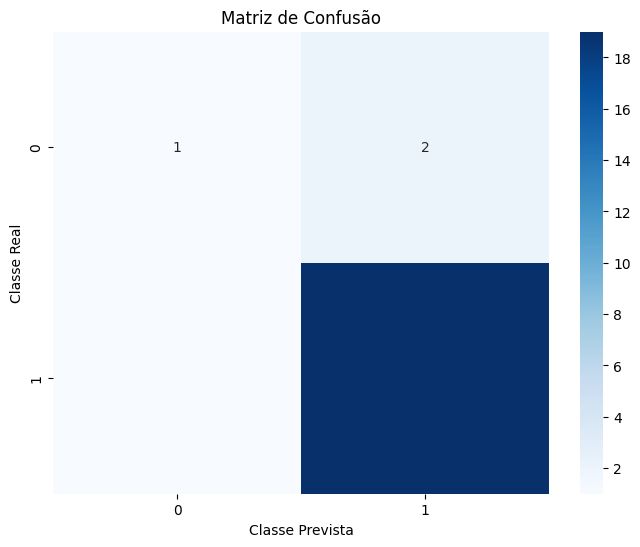

In [26]:
classificador.fit(atributos_treino_smote_all, resposta_treino_smote_all)
classificacao_smote_all = classificador.predict(atributos_teste_smote_all)

relatorio = classification_report(resposta_teste_smote_all, classificacao_smote_all)
print("Relatório de Métricas")
print(relatorio)

classes = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

# Aplicando Decision Tree

In [27]:
metricas = ["accuracy", "precision", "recall", "f1"]
cv = KFold(n_splits=4, shuffle=True, random_state=0)
classificador = DecisionTreeClassifier(criterion="entropy")

for i in metricas:
    print(f"Métrica - {i}")
    score = cross_val_score(classificador, atributos.values, resposta.values, cv=cv, scoring=i)
    print(score,score.mean())

Métrica - accuracy
[0.70833333 0.69565217 0.56521739 0.73913043] 0.6770833333333333
Métrica - precision
[0.75       0.78947368 0.8        0.85      ] 0.7973684210526316
Métrica - recall
[0.82352941 0.78947368 0.63157895 0.85      ] 0.7736455108359134
Métrica - f1
[0.77777778 0.81081081 0.74285714 0.87804878] 0.8023736279833841


In [28]:
tree_gini = DecisionTreeClassifier(criterion="gini")
tree_entropy = DecisionTreeClassifier(criterion="entropy")

tree_gini.fit(atributos_smote, resposta_smote)
tree_entropy.fit(atributos_smote, resposta_smote)

DecisionTreeClassifier(criterion='entropy')

In [29]:
# fig = plt.figure(figsize=(30,7))
# plot_tree(tree_entropy, 
#                    feature_names=atributos.columns,  
#                    class_names=df_olimpo["implementa_app"].unique(),
#                    filled=True)

Entropia
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        20

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



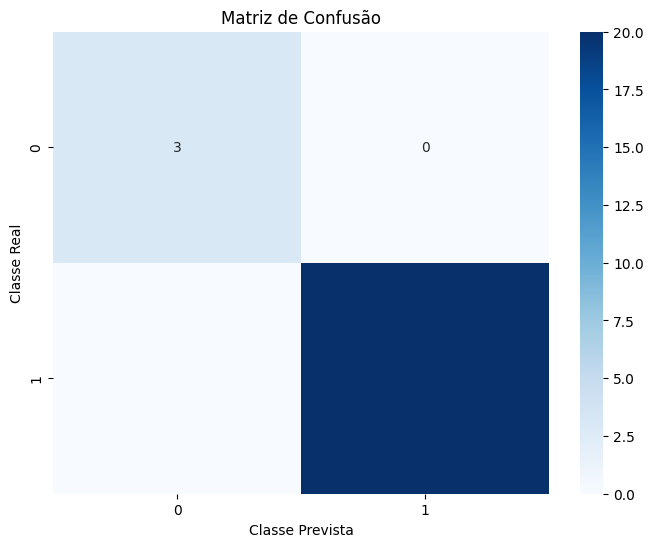

Gini
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00        20

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



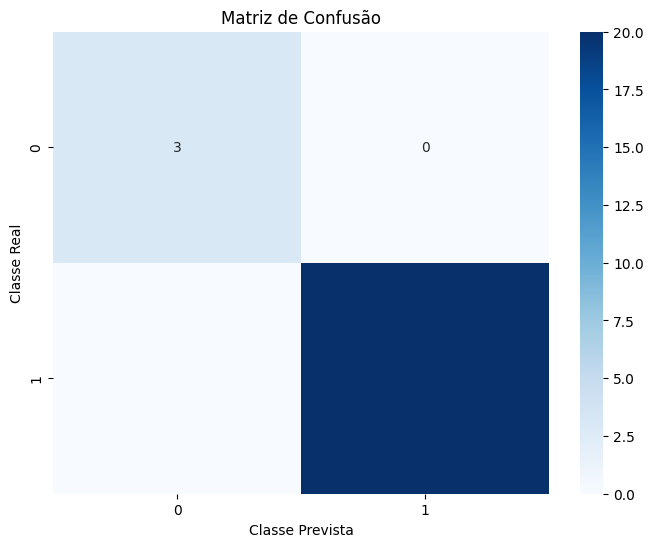

In [30]:
classificacao_entropy = tree_entropy.predict(atributos_teste)
classificacao_gini = tree_gini.predict(atributos_teste)

print("Entropia\n", classification_report(resposta_teste, classificacao_entropy))
matrix = confusion_matrix(resposta_teste, classificacao_entropy)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

print("Gini\n", classification_report(resposta_teste, classificacao_gini))
matrix = confusion_matrix(resposta_teste, classificacao_gini)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')
plt.show()

### Z Score

In [31]:
# #Base Inteira
# formula_zscore = StandardScaler()

# formula_zscore.fit(atributo)

# df_zscore = formula_zscore.transform(atributo)

# df_zscore = pd.DataFrame(df_zscore)

### PCA

In [32]:
# #Base inteira
# pca = PCA(n_components=3)
# pca.fit(df_zscore)
# X_train_pca = pca.transform(df_zscore)
# X_test_pca = pca.transform(df_zscore)